<a href="https://colab.research.google.com/github/RiverGumSecurity/AILabs/blob/main/021_NeuralNetworks/Neural_Networks.ipynb" target="_new"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Learning and Neural Networks with Phishing Email Data

Neural networks are a subset of machine learning algorithms inspired by the human brain's structure and function. They consist of layers of interconnected "neurons" that transform the input data through weighted connections to produce an output. Neural networks are particularly powerful for complex tasks like image recognition and natural language processing.

Neural networks consist of an input layer, one or more hidden layers, and an output layer. These layers consist of "neurons" where each neuron processes input data by applying a weight and an activation function (like sigmoid or ReLU) to produce an output. The training (or learning) process adjusts the weights of the connections between neurons using algorithms like backpropagation and optimization techniques like gradient descent. Neural networks, particularly deep neural networks (deep learning), can model highly complex relationships between inputs and outputs by learning hierarchical feature representations in the hidden layers. Deep learning neural networks typically contain three or more hidden layers.

<center><img src="https://images.edrawsoft.com/articles/neural-network-diagram/example1.png" width="800" height="600"></center>




In [1]:
# import libraries
import numpy as np
import pandas as pd
import nltk
import seaborn as sns
import plotly.express as px
import datetime
import os
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,f1_score,classification_report,ConfusionMatrixDisplay,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding,GRU,LSTM,Bidirectional,SimpleRNN
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Dropout
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Supress debug warnings in training output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages
tf.get_logger().setLevel('ERROR')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

In [3]:
# Set random seed static value for consistent results
seed = 42

In [4]:
# Detect GPU device
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13124922545712340927
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14619377664
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7398080719612947081
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


## Data Acquisition and Preparation

The dataset that will be used to train and test the different models is from https://www.kaggle.com/datasets/subhajournal/phishingemails.  It is pre-labeled as "Safe Email" or "Phishing Email".  The data will be cleaned and prepared for training machine learning models with Pandas.

In [5]:
# Read in the data into a Pandas dataframe
df = pd.read_csv('https://raw.githubusercontent.com/RiverGumSecurity/Datasets/refs/heads/main/Kaggle/Phishing_Email.csv.gz')
df.head(10)

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email
5,5,global risk management operations sally congra...,Safe Email
6,6,"On Sun, Aug 11, 2002 at 11:17:47AM +0100, wint...",Safe Email
7,7,"entourage , stockmogul newsletter ralph velez ...",Phishing Email
8,8,"we owe you lots of money dear applicant , afte...",Phishing Email
9,9,re : coastal deal - with exxon participation u...,Safe Email


In [6]:
# Print information on the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18650 entries, 0 to 18649
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18650 non-null  int64 
 1   Email Text  18634 non-null  object
 2   Email Type  18650 non-null  object
dtypes: int64(1), object(2)
memory usage: 437.2+ KB


In [7]:
# Drop null values in place, drop Unamed:0 column, drop duplicates
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.dropna(inplace=True,axis=0)
df.drop_duplicates(inplace=True)

In [8]:
# Show the shape of the data
df.shape

(17538, 2)

In [9]:
# Display cleaned dataframe
df.head(10)

,Email Text,Email Type
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,the other side of * galicismos * * galicismo *...,Safe Email
2,re : equistar deal tickets are you still avail...,Safe Email
3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,software at incredibly low prices ( 86 % lower...,Phishing Email
5,global risk management operations sally congra...,Safe Email
6,"On Sun, Aug 11, 2002 at 11:17:47AM +0100, wint...",Safe Email
7,"entourage , stockmogul newsletter ralph velez ...",Phishing Email
8,"we owe you lots of money dear applicant , afte...",Phishing Email
9,re : coastal deal - with exxon participation u...,Safe Email


In [10]:
# Display the count of Email types, a Safe Email or a Phishing Email
df['Email Type'].value_counts()

,count
Email Type,
Safe Email,10980
Phishing Email,6558


<Axes: xlabel='Email Type'>

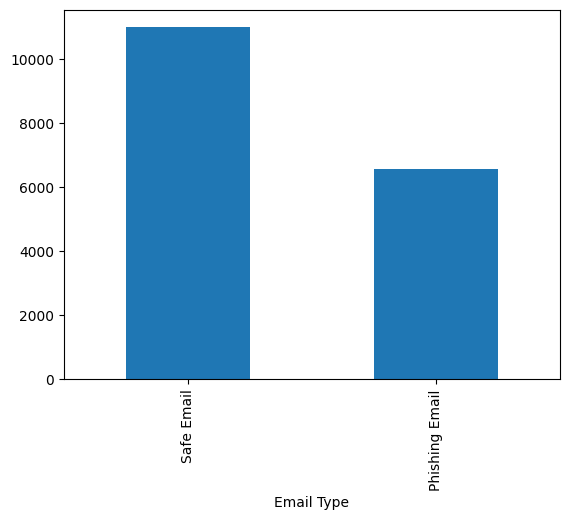

In [11]:
# Plot counts of Safe Email vs Phishing Email
df['Email Type'].value_counts().plot(kind='bar')

Now we need to further process and clean the data. This is a binary classification problem, and we need to assign a label (a 1 or a 0) to the email categories. Then we will remove URLS and non word characters from the emails - we are interested in the similarities of the text itself.  Then we lowercase all of the characters, convert all multiple whitespace characters to single whitespace, and remove any trailing whitespaces.

In [12]:
# Label Email Type
lbl = LabelEncoder()
df['Email Type'] = lbl.fit_transform(df['Email Type'])

In [13]:
# Function to preprocess text.
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text
df['Email Text']=df['Email Text'].apply(preprocess_text)

In [14]:
df.head(10)

,Email Text,Email Type
0,re 6 1100 disc uniformitarianism re 1086 sex l...,1
1,the other side of galicismos galicismo is a sp...,1
2,re equistar deal tickets are you still availab...,1
3,hello i am your hot lil horny toy i am the one...,0
4,software at incredibly low prices 86 lower dra...,0
5,global risk management operations sally congra...,1
6,on sun aug 11 2002 at 111747am 0100 wintermute...,1
7,entourage stockmogul newsletter ralph velez ge...,0
8,we owe you lots of money dear applicant after ...,0
9,re coastal deal with exxon participation under...,1



Because our email messages are variable length, we need to fix the length of each vector we create. In deep learning, it’s often beneficial to have inputs of consistent shapes. Setting max_len ensures that all sequences are padded or truncated to a specific length, allowing you to batch-process sequences more efficiently.

Next we define a simple neural network model using TensorFlow’s Keras Sequential API which is specifically designed for text data and allows you to stack layers in a linear sequence. Each added layer will be executed in the order it’s added, from the first layer to the last.


In [15]:
#Set max_len
max_len = 256

We initalize a new [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) class which is used for preprocessing text data by converting words or characters into numerical representations that a machine learning model can understand. In general, a token is a word or a character.  In our case, a token is a word.

In [16]:
#Initialize new instance of Tokenizer class.
tk = Tokenizer()

The next step is to use `fit_on_texts` method in the 'Tokenizer' class to  processes each text entry in the `Email Text` column of the Pandas data frame to build a vocabulary, where each unique word (or token) is assigned a unique integer index based on its frequency across the entire dataset. It then creates a word index mapping each word (token) to a unique integer in each email.

Then we use the `texts_to_sequences` method to create a list of integer sequence for each email from our word index mappings.  These sequence of integers are then converted to vectors of fixed length (256 from our max_len variable) and padded or truncated as necessary and stored in a numpy array.


In [17]:
# Process the text
tk.fit_on_texts(df['Email Text'])
sequences = tk.texts_to_sequences(df['Email Text'])
vector = pad_sequences(sequences,padding='post', maxlen=max_len)

In [18]:
#Number of rows in the vector numpy array, matches the number of emails in our dataset.
vector.shape[0]

17538

In [19]:
#Length of our word index
len(tk.word_index) + 1

182317

Now we set the `max_features` parameter to limit our overall vocabulary size to the most frequent words. There are two main reasons for this:

- Reduces Memory Usage: In many NLP tasks, datasets contain thousands or millions of unique words. Limiting the vocabulary size to the most frequent words helps reduce memory and computational requirements, which is especially helpful when working with limited resources or large datasets.
- Improves Model Generalization: High vocabulary sizes can lead to overfitting, as the model might memorize rare words that do not generalize well to new data. Setting max_features forces the model to focus on the most important and commonly occurring words, which generally improves performance on unseen data

In [20]:
max_features=10000

Now we split our dataset into training and testing sets using the `train_test_split function` from scikit-learn.  We will train our neural network on 80 percent of the data, then evaluate the accuracy on the remaining 20 percent.

In [21]:
x_train, x_test, y_train, y_test = train_test_split(vector,df['Email Type'], test_size=0.2, random_state =0)

## Training a Simple Recurrent Neural Network

The [`SimpleRNN`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) layer in TensorFlow is a [recurrent neural network (RNN)](https://en.wikipedia.org/wiki/Recurrent_neural_network) layer that processes sequential data, making it suitable for tasks like time series prediction or text generation. Each unit in SimpleRNN maintains a hidden state across time steps, allowing the model to "remember" previous inputs in the sequence. It supports configurations for returning only the final output or the entire sequence, and can also be stacked with other layers for deeper architectures. This layer is simpler and faster than more complex RNN types, like LSTM or GRU, but may struggle with longer sequences.

The first line of code in the next block defines the Sequential model then we add the Embedding layer as the first layer of the model. The third layer is the RNN structure layer, then we add a dropout layer for regularization, and the last layer is a "dense" unit - this is where our binary classifcation probabilities will be output to.

**Embedding Layer**

The Embedding layer is used to convert input words (represented as integer indices) into dense vectors of fixed size.

`len(tk.word_index)+1` is the size of the vocabulary, where tk.word_index is the dictionary of words created by the Tokenizer. Adding 1 ensures that there’s an index for each word plus one additional index, in case we need padding tokens.

50 is the dimensionality of the word embeddings, meaning each word in the vocabulary will be represented by a 50-dimensional vector. This vector captures semantic relationships between words. The `units=100` parameter specifies the number of hidden units in the RNN, meaning the RNN will have 100 output features for each input sequence. Higher units can allow the RNN to capture more complex relationships in the data but can also increase computational requirements.

**Simple RNN Layer**

The Simple RNN layer to the modelprocesses the sequence of embeddings, maintaining a hidden state that captures dependencies between steps (words) in the sequence.

**Dropout Layer**

Dropout is a regularization technique that randomly sets 50% of the neurons in the layer to zero during each training step. This helps prevent overfitting by ensuring that the network doesn’t become too reliant on specific neurons and instead learns more generalized patterns.

**Dense Layer**

The final layer is a dense (fully connected) layer with a single unit.
`1` specifies a single neuron because this model is for a binary classification task. The `activation='sigmoid'` seeting means the output will be a value between 0 and 1, representing a probability. In binary classification, this allows the network to output the probability of a sample belonging to a specific class (e.g., class 1). Other types of tasks for neural networks may use more units in the final dense layer and different activation functions.


In [22]:
model_srnn = Sequential() # Sequential() API
model_srnn.add(Embedding(len(tk.word_index)+1,50))
model_srnn.add(SimpleRNN(units=100))
model_srnn.add(Dropout(0.5))
model_srnn .add(Dense(1, activation='sigmoid'))

Now we "compile" neural network model for training by specifying the loss function, optimizer, and evaluation metrics.

The `binary crossentropy' loss function measures the difference between the predicted probability and the actual label (0 or 1). It is effective for binary classification tasks because it penalizes predictions that deviate from the true class probability, thus helping the model learn to distinguish between the two classes accurately.

The `adam` (Adaptive Moment Estimation) optimizer is a widely used optimization algorithm that adjusts learning rates during training based on estimates of first and second moments of gradients. It combines the advantages of two other optimizers (AdaGrad and RMSProp).

The `accuracy` metric provides an intuitive measure of model performance, especially in binary classification tasks, by indicating the percentage of correct predictions. This metric is tracked and displayed during training, helping to monitor the model’s performance over epochs.


In [23]:
model_srnn.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])

Next we train, or fit, the model to the data (x_train and y_train) for 20 epochs, with a batch size of 16 and evaluate the model on the validation set (x_test and y_test) after each epoch to monitor performance on unseen data.  

Note that and epoch is one complete pass through the data set. The batch size is the number of samples processed before the model’s weights are updated.



In [24]:
historical_srnn  = model_srnn.fit(x_train,y_train, epochs=10, batch_size=16, validation_data=(x_test,y_test))

Epoch 1/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 24s 22ms/step - accuracy: 0.5654 - loss: 0.7074 - val_accuracy: 0.6237 - val_loss: 0.6444
Epoch 2/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 39s 22ms/step - accuracy: 0.6292 - loss: 0.6339 - val_accuracy: 0.6622 - val_loss: 0.6043
Epoch 3/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.6906 - loss: 0.5401 - val_accuracy: 0.6582 - val_loss: 0.5931
Epoch 4/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.6919 - loss: 0.5218 - val_accuracy: 0.6505 - val_loss: 0.6031
Epoch 5/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.6675 - loss: 0.5716 - val_accuracy: 0.6545 - val_loss: 0.6188
Epoch 6/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.6861 - loss: 0.5139 - val_accuracy: 0.6394 - val_loss: 0.6236
Epoch 7/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.6918 - loss: 0.5259 - val_accuracy: 0.6460 - val_loss: 0.6117
Epoch 8/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.7044 - loss: 0.5107 - 

Now we plot the accuracy during training and the loss on the validation set of data. Essentially, we are visualizing how well a model is learning over time. so that we can gauge model performance and identify potential issues.

<u>Training Loss Curve</u>

**Expected Pattern:** The training loss should decrease over time, indicating that the model is improving its predictions on the training data.

**Asymptotic Behavior:** As training progresses, the training loss typically decreases at a slower rate and eventually flattens out as the model approaches its best performance.

**Signs of Overfitting:** If training loss continues to decrease while validation loss starts to increase or levels off, this suggests that the model is beginning to overfit to the training data.

**Irregular Loss Patterns:** Sudden spikes or sharp oscillations might indicate issues like a high learning rate or instability, especially in models with non-convex loss landscapes like neural networks.

<u>Validation Loss Curve</u>

**Expected Pattern:**  Initially, validation loss should decrease along with training loss, showing that the model generalizes well to new data. After some point, however, it may begin to plateau or even increase, which is often a sign of overfitting.

**Ideal Outcome:** A minimal gap between training and validation loss, with both curves reaching a plateau, generally indicates a well-fitting model.

**Increasing Validation Loss:** If validation loss rises while training loss decreases, this suggests overfitting. Early stopping might be needed to halt training at the optimal point before overfitting worsens.

<u>Training Accuracy Curve</u>

**Expected Pattern:** Training accuracy should steadily increase as the model learns patterns in the training data. The curve typically starts lower and climbs until it approaches a high level, ideally plateauing near maximum accuracy for the dataset.

**Unexpected Behavior:** If accuracy is not increasing, the model may be too simple (underfitting) or the learning rate may be set too low. On the other hand, if accuracy increases too quickly without validation accuracy following, it may indicate overfitting.

<u>Validation Accuracy Curve</u>

**Expected Pattern:** Like validation loss, validation accuracy should improve initially along with training accuracy. It should ideally track training accuracy closely, especially as training loss decreases.

**Gap Between Training and Validation Accuracy:** A large gap where training accuracy is high but validation accuracy is low indicates overfitting. Efforts like regularization, data augmentation, or a more complex model might help in closing this gap.

<u>Crossing or Diverging Curves</u>

**Crossing Curves:** If validation loss and accuracy cross significantly (e.g., validation accuracy temporarily surpasses training accuracy), it may indicate randomness in validation performance due to small dataset size or other inconsistencies.

**Diverging Curves:** If validation accuracy remains much lower than training accuracy, even as loss decreases, this often signals that the model is failing to generalize. Adding more data or using a simpler model might help.

<u>Convergence Time</u>

**Slow Convergence:** If the training loss and accuracy improve very slowly, consider adjusting hyperparameters like the learning rate or batch size.

**Rapid Convergence:** If training loss decreases quickly but then stagnates, the model may have a high learning rate or too few epochs to fully learn the data patterns.

<u>Regularization Effects</u>

With Regularization (e.g., Dropout, L2): Training loss may show more fluctuation or be consistently higher compared to models without regularization. This is normal, as regularization prevents the model from memorizing training data too closely, helping validation loss stay low.

Text(0, 0.5, 'Loss')

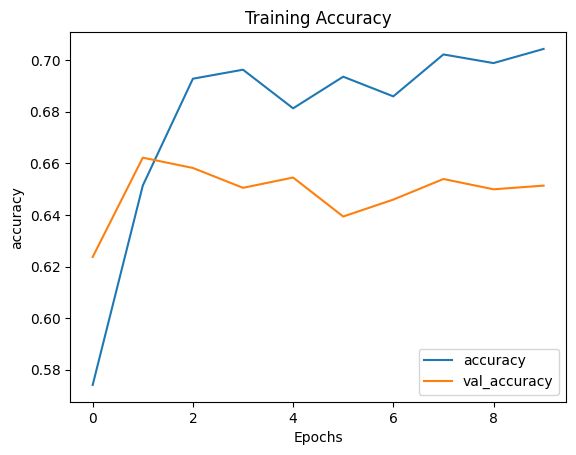

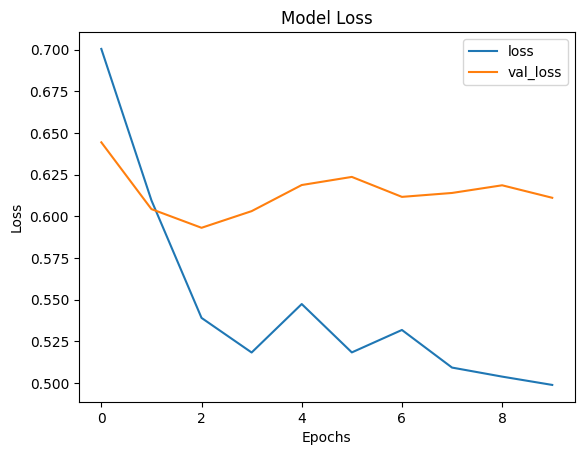

In [25]:

pd.DataFrame(historical_srnn.history)

pd.DataFrame(historical_srnn.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(historical_srnn.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

We also create a confusion matrix like we did with the statistical learning models in the supervised learning lab notebook.  Recall that confusion matrix is a table that summarizes the performance of a classification model by showing the counts of correct and incorrect predictions for each class. It displays true positives, true negatives, false positives, and false negatives, helping to visualize errors and evaluate metrics like accuracy.

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


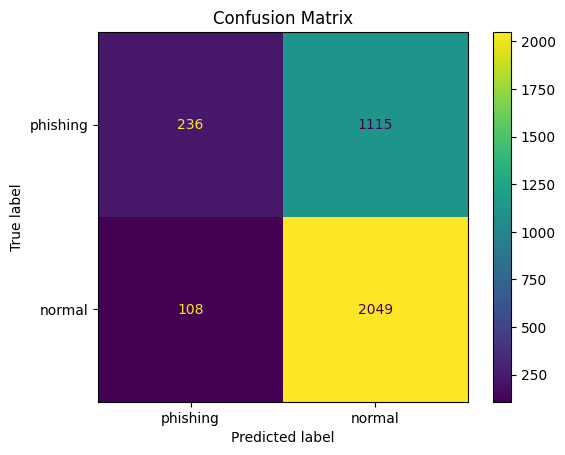

In [26]:
y_pred_prob_smp = model_srnn.predict(x_test)
y_pred_smp = (y_pred_prob_smp > 0.5).astype(int)


cnf_smp = confusion_matrix(y_test,y_pred_smp)
ax_smp = ConfusionMatrixDisplay(confusion_matrix=cnf_smp,display_labels=['phishing','normal']).plot()
plt.title("Confusion Matrix")
plt.show()

In [27]:
# Evaluate the model on the test set
srnn_loss, srnn_accu = model_srnn.evaluate(x_test, y_test, verbose=0)

srnn_accu = (srnn_accu*100)

# Display the accuracy value
print(f'The accuracy of the SRNN model on the test data set was: {srnn_accu:.4f}')

The accuracy of the SRNN model on the test data set was: 65.1368


## LTSM

An LSTM (Long Short-Term Memory) neural network is a type of recurrent neural network (RNN) designed to capture long-term dependencies in sequential data by using memory cells and gating mechanisms to retain or forget information over time. LSTMs are widely used for tasks involving time series data, natural language processing, and sequence prediction, such as forecasting stock prices, analyzing text sentiment, generating music, and translating languages, due to their ability to model and retain patterns over long sequences.

We configure the layers of the model similar to the SRNN model - note the drastic improvement in accuracy.

In [28]:
model_lstm = Sequential() # Sequential() API
model_lstm.add(Embedding(len(tk.word_index)+1,50))
model_lstm.add(LSTM(units=100))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(1, activation='sigmoid'))

In [29]:
model_lstm.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])

In [30]:
historical_lstm  = model_lstm.fit(x_train,y_train, epochs=10, batch_size=16, validation_data=(x_test,y_test))

Epoch 1/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.6437 - loss: 0.6286 - val_accuracy: 0.6670 - val_loss: 0.5838
Epoch 2/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - accuracy: 0.7065 - loss: 0.5420 - val_accuracy: 0.6958 - val_loss: 0.5255
Epoch 3/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.7977 - loss: 0.3837 - val_accuracy: 0.8834 - val_loss: 0.3326
Epoch 4/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.9407 - loss: 0.1966 - val_accuracy: 0.9632 - val_loss: 0.1049
Epoch 5/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.9646 - loss: 0.1235 - val_accuracy: 0.9661 - val_loss: 0.1158
Epoch 6/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.9884 - loss: 0.0450 - val_accuracy: 0.9686 - val_loss: 0.1270
Epoch 7/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9949 - loss: 0.0276 - val_accuracy: 0.9758 - val_loss: 0.1019
Epoch 8/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step - accuracy: 0.9962 - loss: 0.0193 - 

In [31]:
lstm_results = model_lstm.evaluate(x_test, y_test)
lstm_loss = lstm_results[0]  # Extract the loss from the results
lstm_accu = (lstm_results[1]*100)  # Extract the accuracy from the results

print(f"Model Loss: {lstm_loss}")
print(f"Model Accuracy: {lstm_accu}")

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9622 - loss: 0.1096
Model Loss: 0.12601713836193085
Model Accuracy: 95.78106999397278


In [32]:
y_pred_prob = model_lstm.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


Text(0, 0.5, 'Loss')

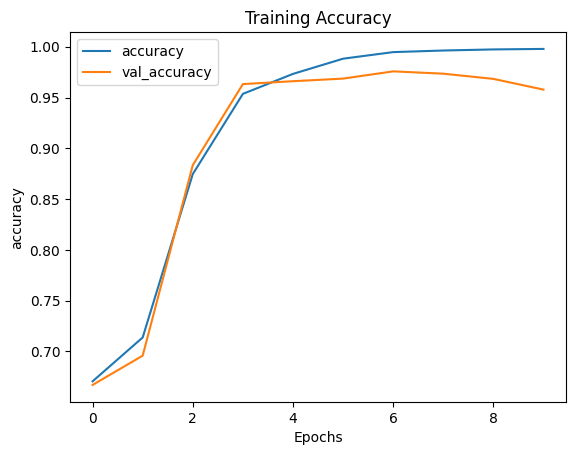

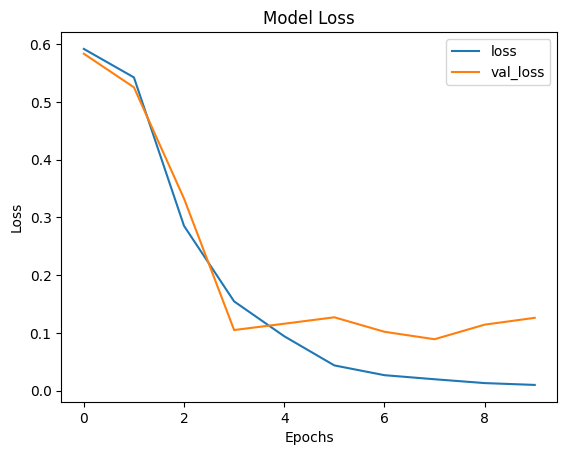

In [33]:
pd.DataFrame(historical_lstm.history)

pd.DataFrame(historical_lstm.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(historical_lstm.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

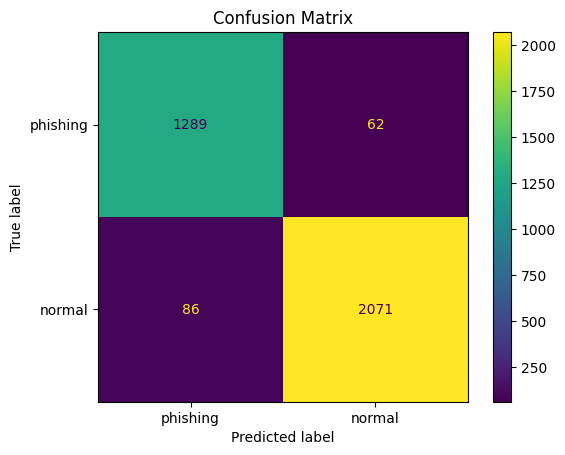

In [34]:
cnf = confusion_matrix(y_test,y_pred)
ax = ConfusionMatrixDisplay(confusion_matrix=cnf,display_labels=['phishing','normal'])
ax.plot()
plt.title("Confusion Matrix")
plt.show()

## Bidirectional

A bidirectional neural network is a type of RNN that processes sequence data in both forward and backward directions, allowing it to capture context from both past and future states. This architecture is particularly useful in natural language processing tasks like speech recognition and text translation, where understanding the full context of a word or phrase requires information from both previous and subsequent elements in the sequence.

In [35]:
model_bi = Sequential() # Sequential() API
model_bi.add(Embedding(len(tk.word_index)+1,50))
model_bi.add(Bidirectional(LSTM(units=100)))
model_bi.add(Dropout(0.5))
model_bi.add(Dense(1, activation='sigmoid'))

In [36]:
model_bi.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])

In [37]:
historical_bi  = model_bi.fit(x_train,y_train, epochs=10, batch_size=16, validation_data=(x_test,y_test))

Epoch 1/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - accuracy: 0.8380 - loss: 0.3563 - val_accuracy: 0.9558 - val_loss: 0.1328
Epoch 2/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 41s 29ms/step - accuracy: 0.9811 - loss: 0.0696 - val_accuracy: 0.9712 - val_loss: 0.0817
Epoch 3/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 40s 29ms/step - accuracy: 0.9939 - loss: 0.0239 - val_accuracy: 0.9786 - val_loss: 0.0738
Epoch 4/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 42s 29ms/step - accuracy: 0.9967 - loss: 0.0126 - val_accuracy: 0.9561 - val_loss: 0.1778
Epoch 5/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - accuracy: 0.9960 - loss: 0.0153 - val_accuracy: 0.9766 - val_loss: 0.0891
Epoch 6/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - accuracy: 0.9964 - loss: 0.0128 - val_accuracy: 0.9524 - val_loss: 0.1399
Epoch 7/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - accuracy: 0.9970 - loss: 0.0144 - val_accuracy: 0.9732 - val_loss: 0.1045
Epoch 8/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - accuracy: 0.9990 - loss: 0.0045 - 

In [38]:
bi_results = model_bi.evaluate(x_test, y_test)
bi_loss = bi_results[0]  # Extract the loss from the results
bi_accu = (bi_results[1]*100)  # Extract the accuracy from the results

print(f"Model Loss: {bi_loss}")
print(f"Model Accuracy: {bi_accu}")

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9725 - loss: 0.1074
Model Loss: 0.12381899356842041
Model Accuracy: 96.80729508399963


In [39]:
y_pred_prob_bi = model_bi.predict(x_test)
y_pred_bi = (y_pred_prob_bi > 0.5).astype(int)

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


Text(0, 0.5, 'Loss')

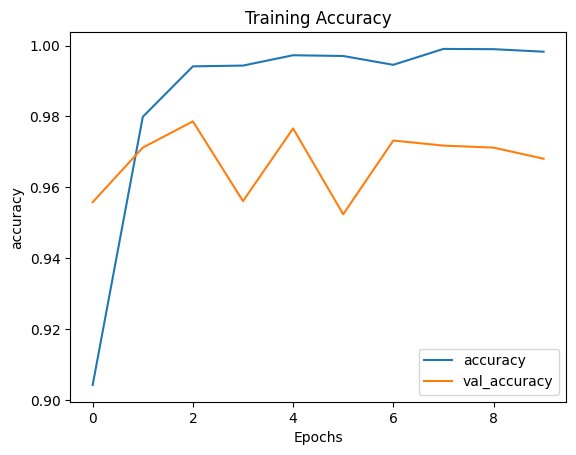

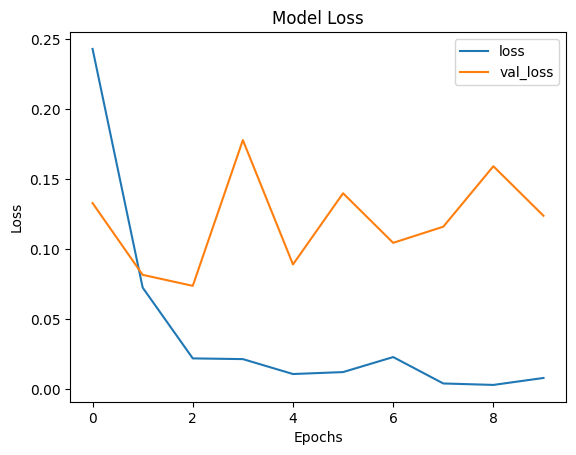

In [40]:
pd.DataFrame(historical_bi.history)

pd.DataFrame(historical_bi.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(historical_bi.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

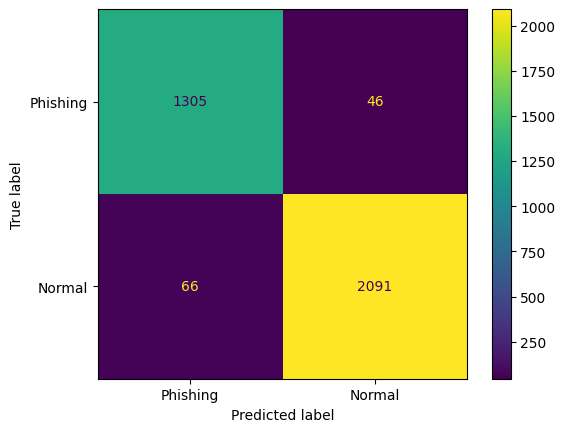

In [41]:
cnf_bi = confusion_matrix(y_test,y_pred_bi)
ax_bi = ConfusionMatrixDisplay(confusion_matrix=cnf_bi,display_labels=['Phishing','Normal'])
ax_bi.plot()
plt.show()

### Gated Recurrent Unit


A Gated Recurrent Unit (GRU) neural network is a type of RNN that uses gating mechanisms to control the flow of information, making it simpler and more computationally efficient than LSTM networks while still capturing dependencies in sequential data. As with the previous models we have explored, GRUs are commonly used in tasks such as time series forecasting, speech recognition, and text generation, where they help to maintain relevant information across sequences without the complexity of LSTM’s multiple gates.

In [42]:
model_gru = Sequential() # Sequential() API
model_gru.add(Embedding(len(tk.word_index)+1,50))
model_gru.add(GRU(units=100))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(1, activation='sigmoid'))

In [43]:
model_gru.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])

In [44]:
historical_gru = model_gru.fit(x_train,y_train, epochs=10, batch_size=16, validation_data=(x_test,y_test))

Epoch 1/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.6322 - loss: 0.6417 - val_accuracy: 0.8010 - val_loss: 0.4694
Epoch 2/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.8578 - loss: 0.3633 - val_accuracy: 0.9641 - val_loss: 0.0958
Epoch 3/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.9829 - loss: 0.0580 - val_accuracy: 0.9615 - val_loss: 0.1091
Epoch 4/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9939 - loss: 0.0217 - val_accuracy: 0.9729 - val_loss: 0.0870
Epoch 5/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.9980 - loss: 0.0085 - val_accuracy: 0.9818 - val_loss: 0.0771
Epoch 6/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.9988 - loss: 0.0066 - val_accuracy: 0.9735 - val_loss: 0.0897
Epoch 7/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.9980 - loss: 0.0065 - val_accuracy: 0.9652 - val_loss: 0.1285
Epoch 8/10
877/877 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.9992 - loss: 0.0024 - 

In [45]:
gru_results = model_gru.evaluate(x_test, y_test)
gru_loss = gru_results[0]  # Extract the loss from the results
gru_accu = (gru_results[1]*100)  # Extract the accuracy from the results

print(f"Model Loss: {gru_loss}")
print(f"Model Accuracy: {gru_accu}")

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9764 - loss: 0.1310
Model Loss: 0.14598716795444489
Model Accuracy: 97.32040762901306


In [46]:
y_pred_prob_gru = model_gru.predict(x_test)
y_pred_gru = (y_pred_prob_gru > 0.5).astype(int)

110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


Text(0, 0.5, 'Loss')

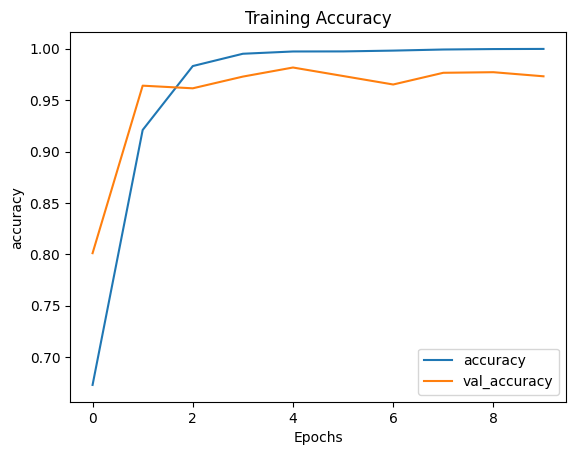

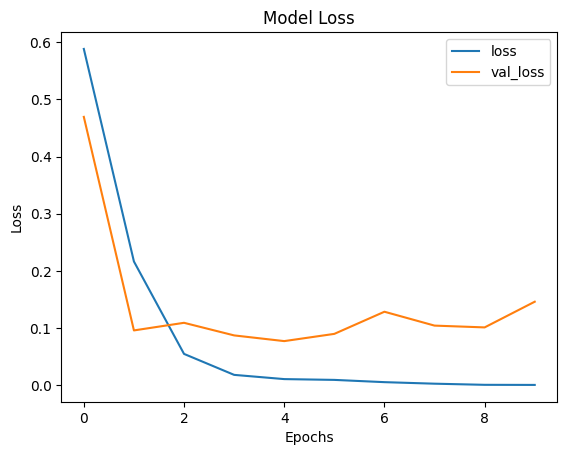

In [47]:
pd.DataFrame(historical_gru.history)

pd.DataFrame(historical_gru.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')

pd.DataFrame(historical_gru.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

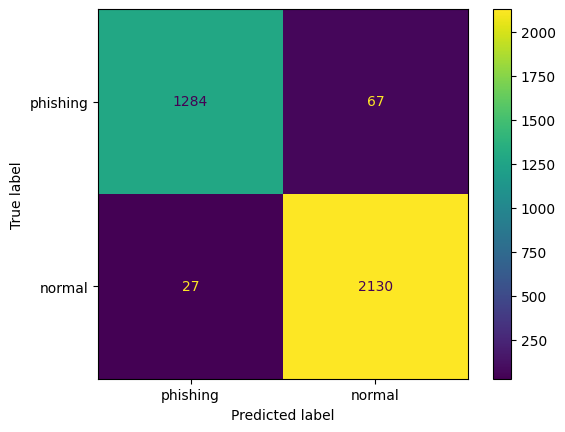

In [48]:
cnf_gru = confusion_matrix(y_test,y_pred_gru)
ax_gru = ConfusionMatrixDisplay(confusion_matrix=cnf_gru,display_labels=['phishing','normal'])
ax_gru.plot()
plt.show()

# Model Comparisons

In [49]:
# set up table of models and comparisons

accu_values = [srnn_accu,lstm_accu, bi_accu, gru_accu]
row_labels = ["Simple RNN", "LSTM Neural Network", "Bidirectional Neural Network", "Gated Recurrent Unit"]
comp_df = pd.DataFrame(accu_values, columns=["accuracy"], index=row_labels)
print(comp_df)

                               accuracy
Simple RNN                    65.136832
LSTM Neural Network           95.781070
Bidirectional Neural Network  96.807295
Gated Recurrent Unit          97.320408


# Class Challenge Exercise

Notice that all of the neural networks we trained in this notebook were not deep learning in the sense that they consisted of one hidden layer.  Tensorflow allows us to stack layers sequentially to make larger networks, however as we seen with accuracy results, more complicated is not always better.  Your challenge is to create a deep learning model that out performs the highest accuracy acheived from all the models tested so far. Can you get above %98.5?

Some suggestions:

- Create more dense neural networks with more layers
- Increase the number of epochs
- Ask an LLM for more ideas...

In [50]:
model_zac = Sequential() # Sequential() API
model_zac.add(Embedding(len(tk.word_index)+1,50))
model_zac.add(Bidirectional(LSTM(units=100)))
model_zac.add(Bidirectional(LSTM(units=100)))

#model_zac.add(GRU(units=100))

model_zac.add(Dropout(0.5))
model_zac.add(Dense(1, activation='sigmoid'))

In [51]:
model_zac.compile(loss='binary_crossentropy' , optimizer='adam', metrics=['accuracy'])

In [52]:
historical_zac = model_zac.fit(x_train,y_train, epochs=10, batch_size=16, validation_data=(x_test,y_test))


Epoch 1/10


ValueError: Input 0 of layer "bidirectional_2" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 200)